**Sources:** It contains the solar power production records in the year of 2006, which is sampled every 10 minutes from 137 PV plants in Alabama State.
- [Basic info](https://github.com/laiguokun/multivariate-time-series-data)
- [Raw Data](http://www.nrel.gov/grid/solar-power-data.html)

⏱️ Measurements were taken every 10 minutes (so 6 per hour x 24 x 365 = 52,560 time steps)

# Imports

In [ ]:
# !pip install spektral
# !pip install scikeras --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
#sir uncomment it to download
 #!wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/solar_AL.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/solar_AL.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/data/solar_preprocessed.csv')

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Columns: 137 entries, 0 to 136
dtypes: float64(137)
memory usage: 54.9 MB


In [ ]:
eda_summary = {
    "shape": df.shape,
    "column_stats": df.describe().T,
    "missing_values": df.isnull().sum().sum(),
    "zero_values": (df == 0).sum().sum(),
    "negative_values": (df < 0).sum().sum(),
    "positive_values": (df > 0).sum().sum(),
    "row_with_all_zero": (df == 0).all(axis=1).sum(),
    "row_with_any_zero": (df == 0).any(axis=1).sum(),
    "row_with_any_negative": (df < 0).any(axis=1).sum()
}


In [ ]:
eda_summary['row_with_any_negative']

np.int64(0)

In [ ]:
len(df[(df==0).all(axis=1)].index)

25993

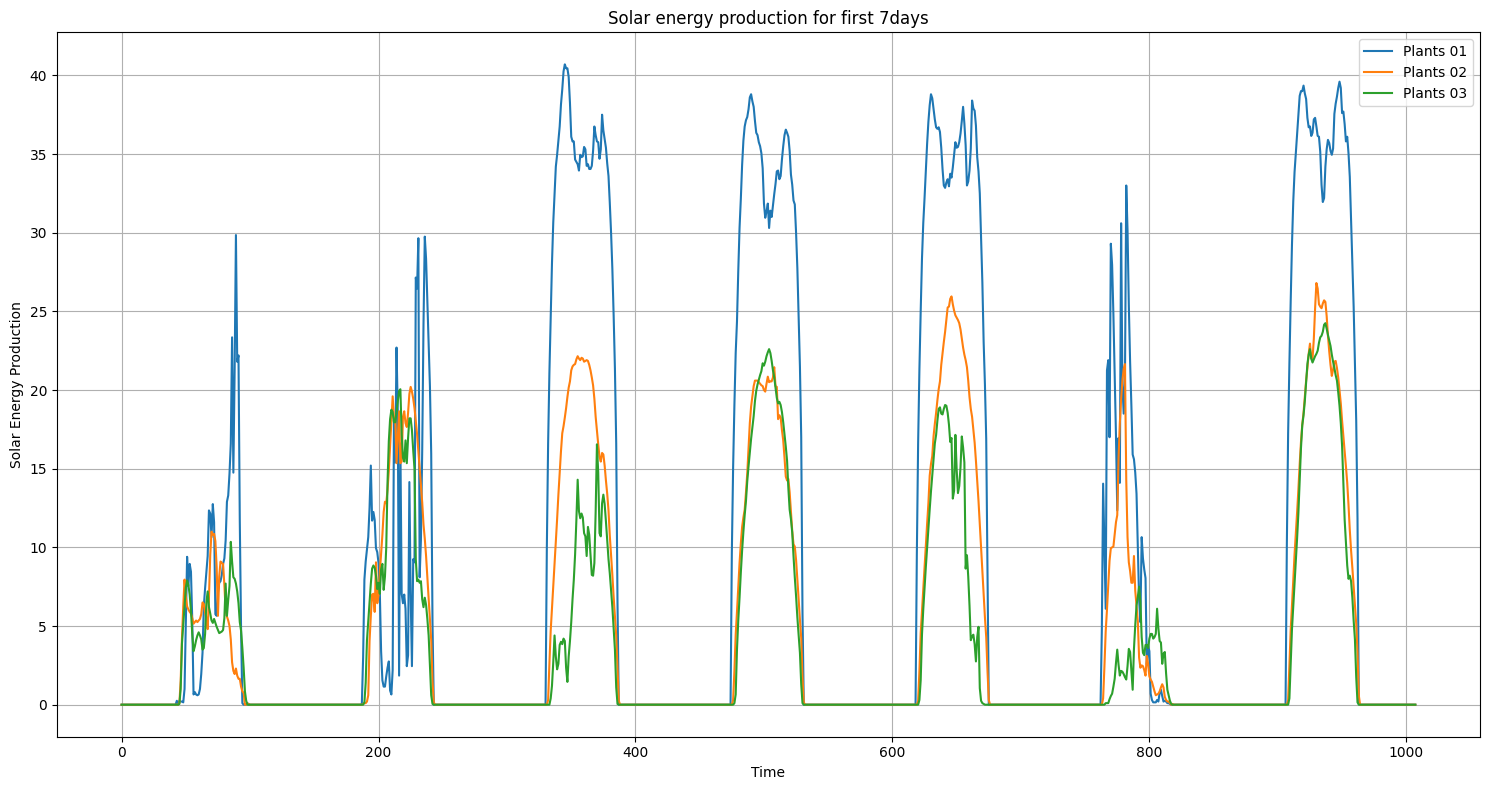

In [ ]:
# Visualizations
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:1008, 0])
plt.plot(df.iloc[:1008, 1])
plt.plot(df.iloc[:1008, 2])
plt.title('Solar energy production for first 7days')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.grid(True)
plt.tight_layout()
plt.show()

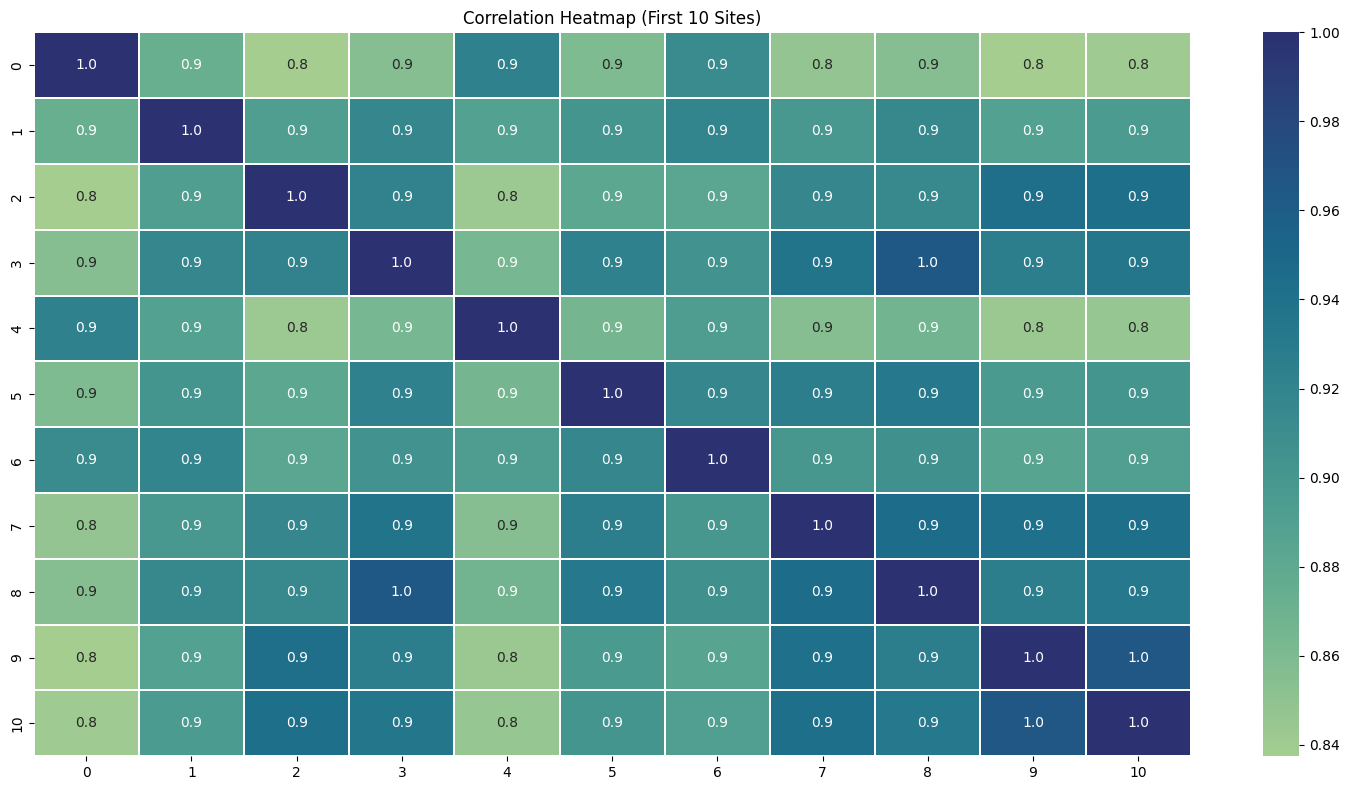

In [ ]:
correlation_subset = df.iloc[:, :11].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='crest', linewidths=0.2, fmt='0.1f')
plt.title('Correlation Heatmap (First 10 Sites)')
plt.tight_layout()
plt.show()


In [ ]:
6*24

144

```
Here's the logic:
In 1 day, there are:

24 hours x 6 entries/hour = 144 entries per day

df.index % 144
→ gives the row number within a day (from 0 to 143)

// 6
→ divides that by 6 to convert from 10-min steps to hour (0 to 23)
```

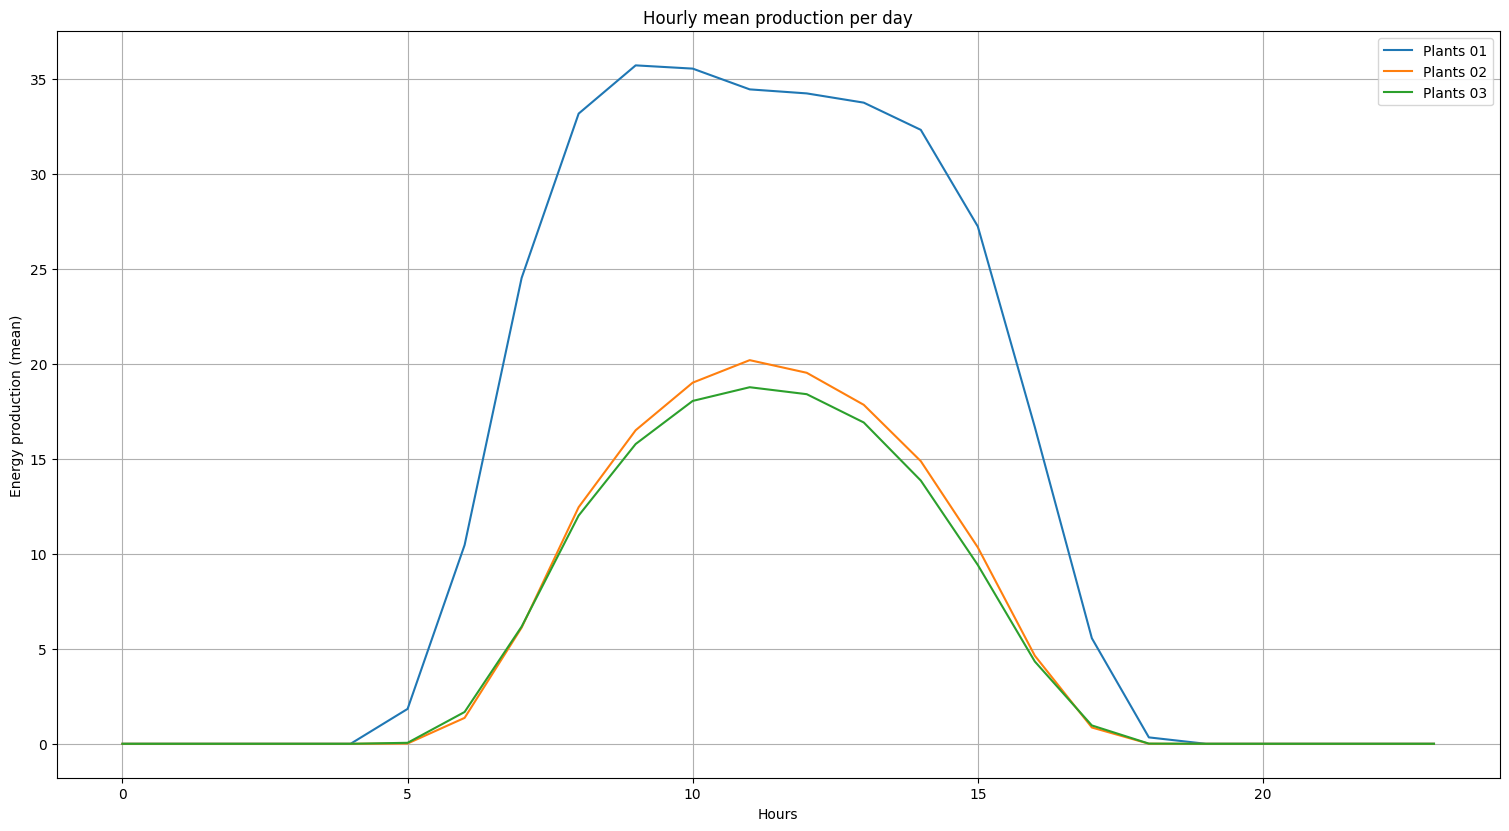

In [ ]:
# Plot average hourly output in a day
df['hours'] = (df.index % 144)//6

plt.figure(figsize=(15,8))
plt.plot(df.groupby(by='hours')[[0,1,2]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hours')
plt.ylabel('Energy production (mean)')
plt.title('Hourly mean production per day')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.show()

In [ ]:
# Create datetime index for full 2006 year (10-min intervals)
date_range = pd.date_range(start='2006-01-01', periods=52560, freq='10min')

# df.index = date_range

df['month'] = date_range.month


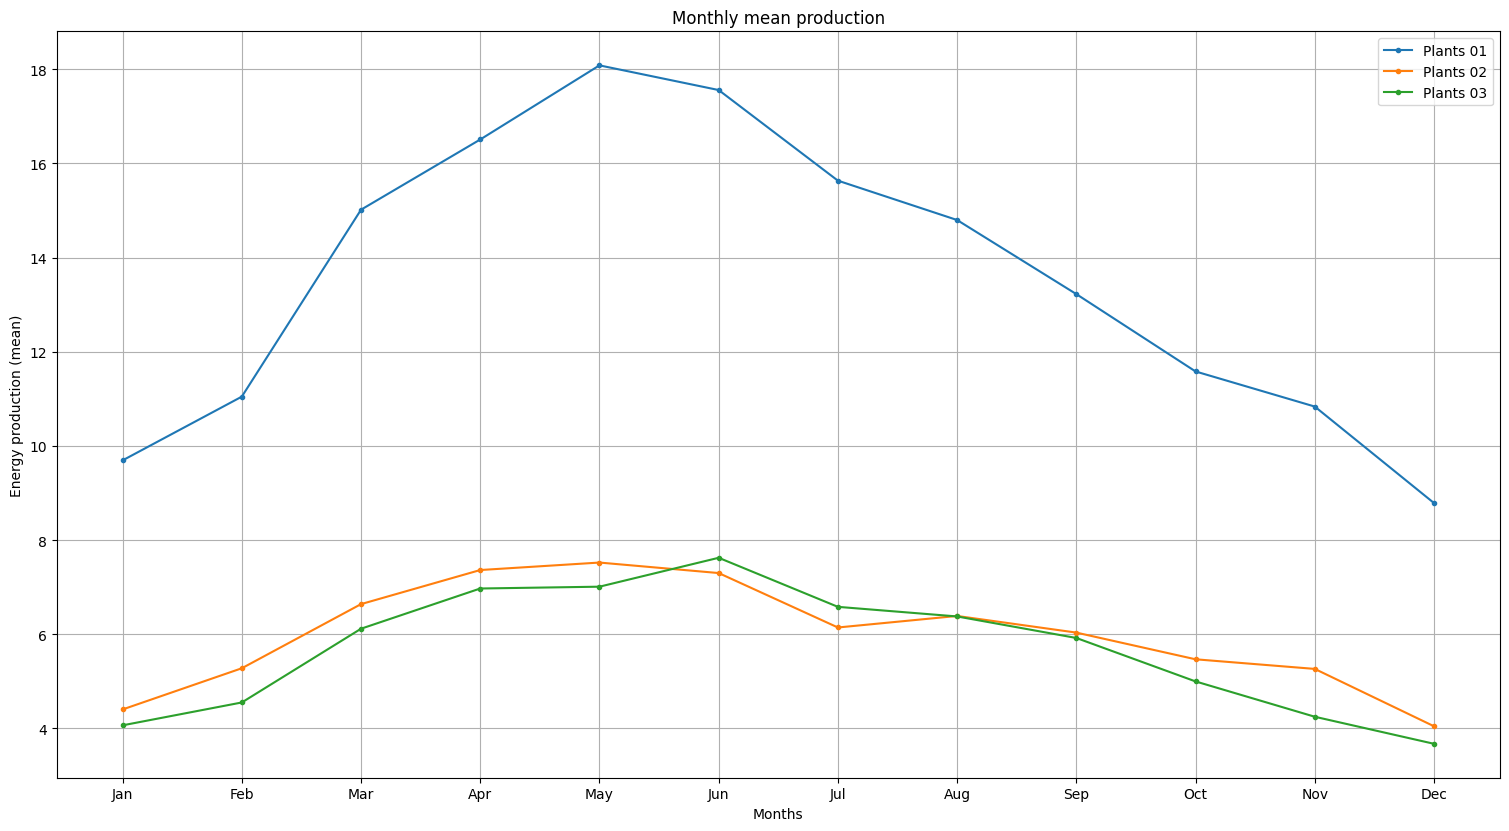

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

# Plot average monthly output (per site)
plt.figure(figsize=(15,8))
plt.plot(range(1, 13), monthly_avg, marker='.')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Energy production (mean)')
plt.title('Monthly mean production')
plt.legend(['Plants 01', 'Plants 02', 'Plants 03'])
plt.show()

In [ ]:
eda_summary['column_stats']

,count,mean,std,min,25%,50%,75%,max
0,52560.0,13.573475,17.611179,0.0,0.0,0.0,30.95,58.85
1,52560.0,5.989026,8.652284,0.0,0.0,0.0,11.45,33.35
2,52560.0,5.683027,8.447994,0.0,0.0,0.0,10.25,33.35
3,52560.0,6.014602,8.841083,0.0,0.0,0.0,11.25,33.15
4,52560.0,11.532876,15.148663,0.0,0.0,0.0,26.35,48.50
...,...,...,...,...,...,...,...,...
132,52560.0,5.659655,8.424734,0.0,0.0,0.0,10.25,31.95
133,52560.0,6.002021,8.669905,0.0,0.0,0.0,11.60,31.85
134,52560.0,5.984339,8.817329,0.0,0.0,0.0,11.10,33.00
135,52560.0,5.746928,7.582154,0.0,0.0,0.0,13.05,24.55


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]
n_nodes = df.shape[1]

In [ ]:
window_size = 168
forecast_horizon = 24  # output sequence length (4 hours)
batch_size = 32

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Modeling

## other models

In [ ]:
def positional_encoding(length, d_model):
    pos = np.arange(length)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

In [ ]:
class TransformerForecast(tf.keras.Model):
    def __init__(self, n_nodes, d_model=128, num_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.input_proj = layers.Dense(d_model)
        self.pos_encoding = positional_encoding(window_size, d_model)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(d_model)
        ])
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.dropout = layers.Dropout(dropout)
        self.output_proj = layers.Dense(n_nodes)

    def call(self, x, training=False):
        x = self.input_proj(x)
        x += self.pos_encoding[tf.newaxis, :, :]
        attn_out = self.attention(x, x)
        x = self.norm1(x + self.dropout(attn_out, training=training))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out, training=training))
        out = self.output_proj(x)
        return out[:, -forecast_horizon:, :]


In [ ]:
class AutoformerBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model // n_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x):
        attn_output = self.mha(x, x)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x

class Autoformer(tf.keras.Model):
    def __init__(self, n_nodes, d_model, n_heads, ff_dim, horizon, dropout=0.1):
        super().__init__()
        self.embed = tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding(window_size, d_model)
        self.blocks = [AutoformerBlock(d_model, n_heads, ff_dim, dropout) for _ in range(2)]
        self.flatten = tf.keras.layers.Flatten()
        self.proj = tf.keras.layers.Dense(horizon * n_nodes)
        self.horizon = horizon
        self.n_nodes = n_nodes

    def call(self, x):
        x = self.embed(x)
        x += self.pos_encoding[:tf.shape(x)[1]]
        for block in self.blocks:
            x = block(x)
        x = self.flatten(x)
        x = self.proj(x)
        return tf.reshape(x, [-1, self.horizon, self.n_nodes])

In [ ]:
class SimpleGCNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None):
        super(SimpleGCNLayer, self).__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        input_dim = input_shape[0][-1]
        self.weight = self.add_weight(
            shape=(input_dim, self.output_dim),
            initializer='glorot_uniform',
            trainable=True,
            name='weight'
        )

    def call(self, inputs):
        x, adj = inputs  # x shape: (batch, nodes, features), adj: (batch, nodes, nodes)
        xw = tf.matmul(x, self.weight)      # (batch, nodes, output_dim)
        out = tf.matmul(adj, xw)            # (batch, nodes, output_dim)
        return self.activation(out) if self.activation else out


def normalize_adj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = np.sum(adj, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv_sqrt = np.diag(d_inv_sqrt)
    return D_inv_sqrt @ adj @ D_inv_sqrt

def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature=(
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


class GNN_LSTM_Model(tf.keras.Model):
    def __init__(self, n_nodes, A_hat, gcn_units=64, lstm_units=64, horizon=24, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.gcn_units = gcn_units
        self.lstm_units = lstm_units

        self.A_hat = tf.convert_to_tensor(A_hat, dtype=tf.float32)  # (nodes, nodes)
        self.gcn = SimpleGCNLayer(gcn_units, activation='relu')
        self.lstm = layers.LSTM(lstm_units)
        self.dense = layers.Dense(horizon * n_nodes)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]

        A_batched = tf.tile(tf.expand_dims(self.A_hat, 0), [batch_size, 1, 1])

        def process_timestep(t):
            x_t = inputs[:, t, :]
            x_t = tf.expand_dims(x_t, -1)
            return self.gcn([x_t, A_batched])

        gcn_outs = tf.map_fn(process_timestep, tf.range(time_steps), dtype=tf.float32)
        gcn_outs = tf.transpose(gcn_outs, perm=[1, 0, 2, 3])

        batch_size_, time_steps_, nodes_, gcn_units_ = tf.unstack(tf.shape(gcn_outs))
        gcn_seq_reshaped = tf.reshape(gcn_outs, [batch_size_, time_steps_, nodes_ * gcn_units_])

        lstm_out = self.lstm(gcn_seq_reshaped)
        dense_out = self.dense(lstm_out)
        output = tf.reshape(dense_out, [batch_size_, self.horizon, self.n_nodes])
        return output


In [ ]:
A = np.ones((df.shape[1], df.shape[1])) - np.eye(df.shape[1])
A_hat = normalize_adj(A)

# Build model
model = GNN_LSTM_Model(
    n_nodes=df.shape[1],
    A_hat=A_hat,
    gcn_units=64,
    lstm_units=64,
    horizon=forecast_horizon
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
model.fit(train_dataset, validation_data=test_dataset, epochs=12, verbose=2)

In [ ]:
@register_keras_serializable()
class LSTM_Model(tf.keras.Model):
    def __init__(self, n_nodes, hidden_dim=128, horizon=24, dropout_rate=0.2, bi=True, n_stack=1, norm=True, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_stack = n_stack
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.norm = norm
        self.norm1 = tf.keras.layers.LayerNormalization()

        if bi:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
          else:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
          self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=False))
        else:
          if n_stack <= 1:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)
          else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
          self.lstm2 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.norm :
          x = self.norm1(x)
        for i in range(self.n_stack - 1):
          x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        return tf.reshape(x, (-1, self.horizon, self.n_nodes))


    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate":self.dropout_rate,
            "bi" : self.bi,
            "n_stack":self.n_stack,
            "norm": self.norm
        })
        return config

In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 256
forecast_horizon = 24

model = LSTM_Model(
                    n_nodes = n_nodes,
                    hidden_dim = hidden_dim,
                    horizon = forecast_horizon,
                    dropout_rate = 0.1,
                    bi = False,
                    n_stack=1,
                    norm=False
                    )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'lstm__model_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


   1310/Unknown 30s 22ms/step - loss: 0.0251 - mae: 0.0968

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1311/1311 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - loss: 0.0251 - mae: 0.0968 - val_loss: 0.0175 - val_mae: 0.0783
Epoch 2/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - loss: 0.0111 - mae: 0.0622 - val_loss: 0.0112 - val_mae: 0.0578
Epoch 3/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 35s 27ms/step - loss: 0.0095 - mae: 0.0558 - val_loss: 0.0103 - val_mae: 0.0558
Epoch 4/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0089 - mae: 0.0533 - val_loss: 0.0097 - val_mae: 0.0538
Epoch 5/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 0.0084 - mae: 0.0515 - val_loss: 0.0092 - val_mae: 0.0532
Epoch 6/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 33s 25ms/step - loss: 0.0081 - mae: 0.0501 - val_loss: 0.0089 - val_mae: 0.0525
Epoch 7/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0080 - mae: 0.0495 - val_loss: 0.0087 - val_mae: 0.0505
Epoch 8/50
1311/1311 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - loss: 0.0077 - mae: 0.0479 - val_loss: 0.0093 - val_mae: 0.0530
Epoch 9/50
1311/1311 ━━━━━━━━━━━━━━

## working

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.2,
                 bi=True, n_stack=1, en_norm=True, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.n_heads = n_heads
        self.horizon = horizon
        self.n_stack = n_stack
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm

        self.norm = tf.keras.layers.LayerNormalization()

        # Stacked LSTM block
        if bi:
            d_model = hidden_dim * 2
            self.lstm_stack = tf.keras.Sequential([
                tf.keras.layers.Bidirectional(
                    tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
                ) for _ in range(n_stack)
            ])
            self.lstm2 = tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(hidden_dim, return_sequences=False)
            )
        else:
            d_model = hidden_dim
            self.lstm_stack = tf.keras.Sequential([
                tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
                for _ in range(n_stack)
            ])
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim, return_sequences=False)

        # Attention block
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model)
        self.attn_add = tf.keras.layers.Add()
        self.attn_norm = tf.keras.layers.LayerNormalization()

        # Feed-Forward Network block
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(2 * d_model, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        self.ffn_add = tf.keras.layers.Add()
        self.ffn_norm = tf.keras.layers.LayerNormalization()

        # Final projection
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.en_norm:
            x = self.norm(x)
        x = self.lstm_stack(x)
        attn_out = self.attn(x, x, x)
        x = self.attn_add([x, attn_out])
        x = self.attn_norm(x)

        ffn_out = self.ffn(x)
        x = self.ffn_add([x, ffn_out])
        x = self.ffn_norm(x)

        x = self.lstm2(x)
        x = self.dropout(x)
        x = self.fc(x)
        out = tf.reshape(x, (-1, self.horizon, self.n_nodes))
        return out

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "n_heads": self.n_heads,
            "hidden_dim": self.hidden_dim,
            "horizon": self.horizon,
            "dropout_rate": self.dropout_rate,
            "bi": self.bi,
            "n_stack": self.n_stack,
            "en_norm": self.en_norm,
        })
        return config


In [ ]:
n_nodes = df_train.shape[1]
hidden_dim = 128
forecast_horizon = 24

model = TalNet(
                    n_nodes = n_nodes,
                    hidden_dim = hidden_dim,
                    n_heads=2,
                    horizon = forecast_horizon,
                    dropout_rate = 0.2,
                    bi = False,
                    n_stack=1,
                    en_norm=False,
                    )

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'tal_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


   1308/Unknown 1202s 913ms/step - loss: 0.0297 - mae: 0.1125

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1304s 991ms/step - loss: 0.0297 - mae: 0.1125 - val_loss: 0.0223 - val_mae: 0.0822
Epoch 2/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1268s 969ms/step - loss: 0.0157 - mae: 0.0741 - val_loss: 0.0152 - val_mae: 0.0641
Epoch 3/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1314s 1s/step - loss: 0.0116 - mae: 0.0607 - val_loss: 0.0135 - val_mae: 0.0638
Epoch 4/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1293s 989ms/step - loss: 0.0109 - mae: 0.0581 - val_loss: 0.0131 - val_mae: 0.0628
Epoch 5/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1282s 980ms/step - loss: 0.0109 - mae: 0.0582 - val_loss: 0.0129 - val_mae: 0.0572
Epoch 6/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1300s 994ms/step - loss: 0.0095 - mae: 0.0528 - val_loss: 0.0120 - val_mae: 0.0584
Epoch 7/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 0s 902ms/step - loss: 0.0091 - mae: 0.0512

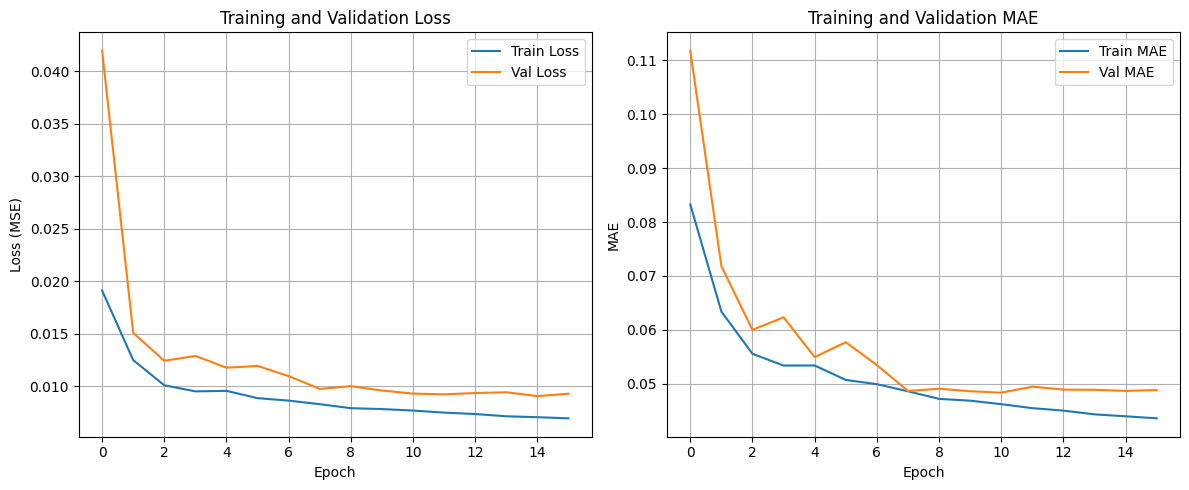

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
@tf.keras.utils.register_keras_serializable()
class TalNetV2(tf.keras.Model):
    def __init__(self, n_nodes, horizon, n_heads=4, hidden_dim=128, dropout_rate=0.1,
                 bi=False, n_stack=1, en_norm=False, node_emb_dim=16, **kwargs):
        super().__init__(**kwargs)
        self.n_nodes = n_nodes
        self.horizon = horizon
        self.n_heads = n_heads
        self.hidden_dim = hidden_dim
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.bi = bi
        self.en_norm = en_norm
        self.node_emb_dim = node_emb_dim

        self.node_embedding = tf.keras.layers.Embedding(input_dim=n_nodes, output_dim=node_emb_dim)
        self.norm = tf.keras.layers.LayerNormalization()
        self.temporal_conv = tf.keras.layers.Conv1D(
                                                    filters=hidden_dim, kernel_size=3,
                                                    padding='causal', activation='relu'
                                                    )

        if bi:
            self.lstm1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim, return_sequences=True))
            self.lstm2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False))
            self.d_model = hidden_dim * 2
        else:
            self.lstm1 = tf.keras.layers.LSTM(hidden_dim, return_sequences=True)
            self.lstm2 = tf.keras.layers.LSTM(hidden_dim // 2, return_sequences=False)
            self.d_model = hidden_dim

        self.transformer_blocks = []
        for _ in range(n_stack):
            self.transformer_blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=self.d_model),
                "attn_add": tf.keras.layers.Add(),
                "attn_norm": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(2 * self.d_model, activation='relu'),
                    tf.keras.layers.Dense(self.d_model),
                ]),
                "ffn_add": tf.keras.layers.Add(),
                "ffn_norm": tf.keras.layers.LayerNormalization()
            })

        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x):
        if self.en_norm:
            x = self.norm(x)

        batch_size = tf.shape(x)[0]
        time_steps = tf.shape(x)[1]

        node_ids = tf.range(self.n_nodes)
        node_emb = self.node_embedding(node_ids)
        node_emb_exp = tf.expand_dims(node_emb, 0)
        node_emb_exp = tf.expand_dims(node_emb_exp, 0)
        node_emb_tiled = tf.tile(node_emb_exp, [batch_size, time_steps, 1, 1])

        x_exp = tf.expand_dims(x, -1)
        x_concat = tf.concat([x_exp, node_emb_tiled], axis=-1)

        x_reshaped = tf.reshape(x_concat, [batch_size * self.n_nodes, time_steps, 1 + self.node_emb_dim])
        x_conv = self.temporal_conv(x_reshaped)
        x_conv_reshaped = tf.reshape(x_conv, [batch_size, time_steps, self.n_nodes, self.hidden_dim])
        x_for_lstm = tf.reshape(x_conv_reshaped, [batch_size, time_steps, self.n_nodes * self.hidden_dim])

        x_lstm1 = self.lstm1(x_for_lstm)

        x = x_lstm1
        for block in self.transformer_blocks:
            attn_out = block["attn"](x, x, x)
            x = block["attn_add"]([x, attn_out])
            x = block["attn_norm"](x)

            ffn_out = block["ffn"](x)
            x = block["ffn_add"]([x, ffn_out])
            x = block["ffn_norm"](x)

        x_lstm2 = self.lstm2(x)
        x_drop = self.dropout(x_lstm2)
        x_out = self.fc(x_drop)
        out = tf.reshape(x_out, [batch_size, self.horizon, self.n_nodes])

        return out


In [ ]:
model = TalNetV2(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    n_heads=2,
    hidden_dim=32,
    dropout_rate=0.1,
    bi=False,
    n_stack=1,
    en_norm=False,
    node_emb_dim=8
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'tal_net_v2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


   1308/Unknown 63s 42ms/step - loss: 0.0307 - mae: 0.1098

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1308/1308 ━━━━━━━━━━━━━━━━━━━━ 72s 48ms/step - loss: 0.0307 - mae: 0.1098 - val_loss: 0.0202 - val_mae: 0.0761
Epoch 2/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - loss: 0.0158 - mae: 0.0767 - val_loss: 0.0193 - val_mae: 0.0759
Epoch 3/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - loss: 0.0147 - mae: 0.0729 - val_loss: 0.0154 - val_mae: 0.0664
Epoch 4/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 62s 48ms/step - loss: 0.0125 - mae: 0.0642 - val_loss: 0.0213 - val_mae: 0.0716
Epoch 5/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 61s 46ms/step - loss: 0.0126 - mae: 0.0650 - val_loss: 0.0116 - val_mae: 0.0544
Epoch 6/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 64s 49ms/step - loss: 0.0104 - mae: 0.0565 - val_loss: 0.0123 - val_mae: 0.0535
Epoch 7/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 61s 47ms/step - loss: 0.0099 - mae: 0.0546 - val_loss: 0.0132 - val_mae: 0.0539
Epoch 8/50
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 143s 93ms/step - loss: 0.0094 - mae: 0.0531 - val_loss: 0.0129 - val_mae: 0.0528
Epoch 9/50
1308/1308 ━━━━━━━━━━━━━

# Final

In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }


In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)

323/323 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


In [ ]:
print(f'Model Name: Stacked LSTM')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: Stacked LSTM
Step 3  --> RSE=0.2150, CORR=0.9774
Step 6  --> RSE=0.2369, CORR=0.9726
Step 12 --> RSE=0.2909, CORR=0.9583
Step 24 --> RSE=0.3823, CORR=0.9285


In [ ]:
print(f'Model Name: TALnet')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: TALnet
Step 3  --> RSE=0.2704, CORR=0.9648
Step 6  --> RSE=0.2832, CORR=0.9617
Step 12 --> RSE=0.3238, CORR=0.9501
Step 24 --> RSE=0.4062, CORR=0.9197


In [ ]:
print(f'Model Name: TalNetV2')
for step in [3, 6, 12, 24]:
    rse, corr = step_rse_corr(y_test, y_pred, step)
    print(f"Step {str(step):3s}--> RSE={rse:.4f}, CORR={corr:.4f}")

Model Name: TalNetV2
Step 3  --> RSE=0.2542, CORR=0.9675
Step 6  --> RSE=0.2666, CORR=0.9642
Step 12 --> RSE=0.3074, CORR=0.9520
Step 24 --> RSE=0.3864, CORR=0.9238


In [ ]:
print(f'Model Name: TalNetV2')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: TalNetV2
Step  3 --> R²=0.9354, RMSE=0.0603, MAE=0.0322, MSE=0.0036, SMAPE=138.41%, RSE=0.2542, CORR=0.9675
Step  6 --> R²=0.9289, RMSE=0.0632, MAE=0.0332, MSE=0.0040, SMAPE=139.33%, RSE=0.2666, CORR=0.9642
Step 12 --> R²=0.9055, RMSE=0.0729, MAE=0.0371, MSE=0.0053, SMAPE=141.33%, RSE=0.3074, CORR=0.9520
Step 24 --> R²=0.8507, RMSE=0.0916, MAE=0.0461, MSE=0.0084, SMAPE=143.78%, RSE=0.3864, CORR=0.9238


In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/solar_biLSTM.keras')

In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/solar_biLSTM.keras',
#     custom_objects={'LSTM_Model': LSTM_Model}
# )

In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/LSTMStackTransformer_solar.keras')


In [ ]:
# model = load_model(
#     '/content/drive/MyDrive/data/varsity/LSTMStackTransformer_solar.keras',
#     custom_objects={'LSTM_Attention_Model': LSTM_Attention_Model}
# )

In [ ]:
model.save('/content/drive/MyDrive/data/varsity/TalNetV2_solar.keras')

In [ ]:
model = load_model(
    '/content/drive/MyDrive/data/varsity/TalNetV2_solar.keras',
    custom_objects={'TalNetV2': TalNetV2}
)